# Part 2. EDA and Pre-processing

## Importing Libraries

In [1]:
# Import Data Manipulation Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Importing NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer          
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Import Vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Importing the dataset

In [2]:
# Read csv
post_df = pd.read_csv('../datasets/coursera_edx_posts_f.csv',index_col=[0])
cmt_df = pd.read_csv('../datasets/coursera_edx_comments_f.csv',index_col=[0])

In [3]:
# Check head of posts
post_df.head()

,name,title,selftext,ups,upvote_ratio,permalink,subreddit
0,t3_y144xh,How to do a Masters in a completely unrelated ...,"Hi guys,\n\nI'm close to finishing my Bachelor...",8,0.90,/r/edX/comments/y144xh/how_to_do_a_masters_in_...,edX
1,t3_y09o1m,The consequences of failing a course after get...,I made a huge mistake!\nI took to courses one ...,10,0.86,/r/edX/comments/y09o1m/the_consequences_of_fai...,edX
2,t3_xxluk0,Auditing a Course,"If you audit a course, do you have access to t...",2,0.67,/r/edX/comments/xxluk0/auditing_a_course/,edX
3,t3_xtszjt,APA Format Citation Guide,1. APA Referencing Basics: Reference List\nA r...,3,0.81,/r/edX/comments/xtszjt/apa_format_citation_guide/,edX
4,t3_xtm1ea,Possibility to access old courses?,"Hi, I wonder if there are possibilities to acc...",7,0.79,/r/edX/comments/xtm1ea/possibility_to_access_o...,edX


In [4]:
# Rename column in comments to match post
cmt_df.columns = ['link_id','subreddit','title']

In [5]:
# Check head of comments
cmt_df.head()

,link_id,subreddit,title
0,t3_y09o1m,edX,"Financial aid just gives u a discount, you sti..."
1,t3_xxluk0,edX,Not necessarily. Assignments are only for cert...
2,t3_xtm1ea,edX,You can just access archived courses even if n...
3,t3_xsaqli,edX,Cs50 python is more about learning the python ...
4,t3_xseepw,edX,I’m taking it. I don’t like it but I will comp...


In [6]:
# Check subreddit
post_df['subreddit'].unique()

array(['edX', 'coursera'], dtype=object)

In [7]:
# Uncapitalize target varible
post_df['subreddit'] = post_df['subreddit'].apply(lambda x : x.lower())
cmt_df['subreddit'] = cmt_df['subreddit'].apply(lambda x : x.lower())

In [8]:
# Check shape
post_df.shape, cmt_df.shape

((1994, 7), (1582, 3))

In [9]:
# Check types
post_df.dtypes

name             object
title            object
selftext         object
ups               int64
upvote_ratio    float64
permalink        object
subreddit        object
dtype: object

In [10]:
# Check types
cmt_df.dtypes

link_id      object
subreddit    object
title        object
dtype: object

## Feature Engineering Lengths and Counts

Posts

In [11]:
# Create columns - length and  count
post_df['title_length'] = post_df['title'].apply(lambda x : len(x))
post_df['title_count'] = post_df['title'].apply(lambda x : len(x.split()))

Comments

In [12]:
# Create columns - length and  count
cmt_df['title_length'] = cmt_df['title'].apply(lambda x : len(x))
cmt_df['title_count'] = cmt_df['title'].apply(lambda x : len(x.split()))

## Create a stemmed title column and lemmatized title column

In [13]:
def lemma(string):
    # Lemmatize title
    # Tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    string_token = tokenizer.tokenize(string.lower())
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    string_lemma = [lemmatizer.lemmatize(word) for word in string_token]
    # Return joined string
    return ' '.join(string_lemma)

In [14]:
def stemmi(string):
    # Lemmatize title
    # Tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    string_token = tokenizer.tokenize(string.lower())
    # Stemming
    p_stemmer = PorterStemmer()
    string_stem = [p_stemmer.stem(word) for word in string_token]
    # Return joined string
    return ' '.join(string_stem)

In [15]:
# Creating lemmatizing and stemming columns
# Create for post df
post_df['title_lemma'] = post_df['title'].apply(lambda x : lemma(x))
post_df['title_stem'] = post_df['title'].apply(lambda x : stemmi(x))
# Create for comment df
cmt_df['title_lemma'] = cmt_df['title'].apply(lambda x : lemma(x))
cmt_df['title_stem'] = cmt_df['title'].apply(lambda x : stemmi(x))

## Save to cleaned csv for Model Comparison

In [16]:
# Export to csv
post_df.to_csv('../datasets/coursera_edx_posts_cleaned.csv')
cmt_df.to_csv('../datasets/coursera_edx_comments_cleaned.csv')

---

## Split DataFrame for EDA

In [17]:
# Splitting dataframe
# Posts
edx_post = post_df[post_df['subreddit']=='edx']
coursera_post = post_df[post_df['subreddit']=='coursera']

# Comments
edx_cmts = cmt_df[cmt_df['subreddit']=='edx']
coursera_cmts = cmt_df[cmt_df['subreddit']=='coursera']

---

## EDA on texts in `title` for both the Udemy and Coursera threads

#### Stopwords

In [18]:
# Manually adding stopwords
manual_stopwords = stopwords.words('english')

# List of keywords to add
edx_list = ['edx','http','www','org','course'] 
coursera_list = ['coursera']

# Add to stopwords
manual_stopwords.extend(edx_list)
manual_stopwords.extend(coursera_list)

#### Creating functions to plot comparison of top words

In [19]:
# Create a function to vectorize and return dataframe

def vec_to_df(vec=CountVectorizer(),data=post_df['title']):
    # Vectorize using own choice and return vectorized dataframe
    
    # fit transform title
    d = vec.fit_transform(data)
    
    # Storing into a DataFrame
    df_vec = pd.DataFrame(d.todense(),columns=vec.get_feature_names_out())
    
    return df_vec

In [20]:
# Create a function to plot top recurring words

def plot_top_words(left_df=edx_post,right_df=coursera_post,
                   top_n=15,title='Top 15 Words'):
    # Plot a comparison of top words mac vs windows
    
    # Generate figures
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6),sharex=True)
    
    # Plot for Udemy
    left_df.sum().sort_values(ascending=False).head(top_n).\
    plot(kind='barh', ax=ax1, color = '#010000')
    ax1.set_title('EdX')
    
    # Plot for Coursera
    right_df.sum().sort_values(ascending=False).head(top_n).\
    plot(kind='barh', ax=ax2, color = '#0255d1')
    ax2.set_title('Coursera')
    
    # Plot suptitle
    plt.suptitle(title)
    plt.tight_layout()

In [21]:
def compare_words(vec_choice='cv', grams=(1,1), left_df=edx_post, 
                  right_df= coursera_post, top_n=15, feature = 'title',
                  title='Top 15 Words'):
    
    # Select vectorizer and combine vec_to_df and plot_top_words
    
    # Selecting vectorizer choice
    if vec_choice == 'cv':
        vec = CountVectorizer(stop_words=manual_stopwords,
                              ngram_range=grams)
    elif vec_choice == 'tf':
        vec = TfidfVectorizer(stop_words=manual_stopwords,
                              ngram_range=grams)
            
    # Split mac and window then vectorize   
    edx_df  = vec_to_df(vec=vec,data=left_df[feature])
    coursera_df  = vec_to_df(vec=vec,data=right_df[feature])
    
    # Plot to compare
    plot_top_words(left_df = edx_df,
                   right_df = coursera_df,
                   top_n = top_n,
                   title = title)

---

## Text Normalizing Options: Lemmatize vs Stemming

Before analysing words in the title, we need to decide whether we should lemmatize, stem, or simply just vectorize our title. In order to decide we will plot the top recurring words - unigram only - and select methods that best help us carry out our EDA.

**Stemming** <br>
- Stemming is a natural language processing technique that lowers inflection in words to their root forms, hence aiding in the preprocessing of text, words, and documents for text normalization.

**Lemmatizing** <br>
- Unlike stemming which chop off the given word to its root word ‘Lemmatization’ is a almost similar but it always return you the chopped word which has some dictionary meaning.

### Vectorize only for comparison - *Count Vectorizer* 

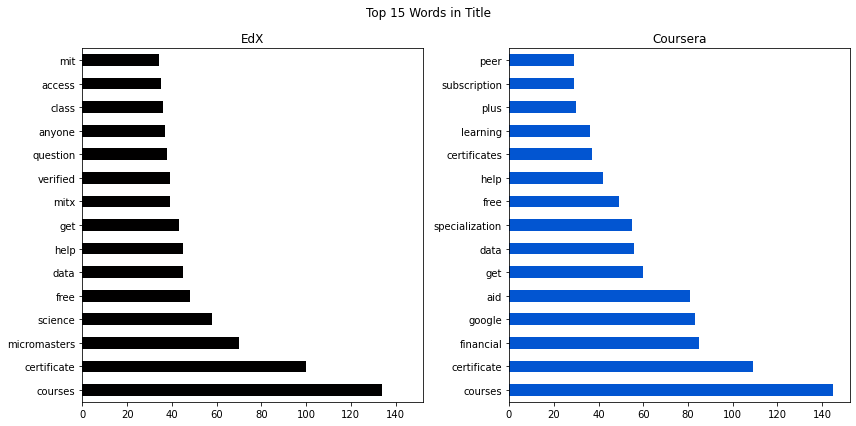

In [22]:
compare_words(vec_choice='cv',grams=(1,1),top_n=15, feature = 'title',
              title='Top 15 Words in Title')

### Stemming - *Count Vectorizer*

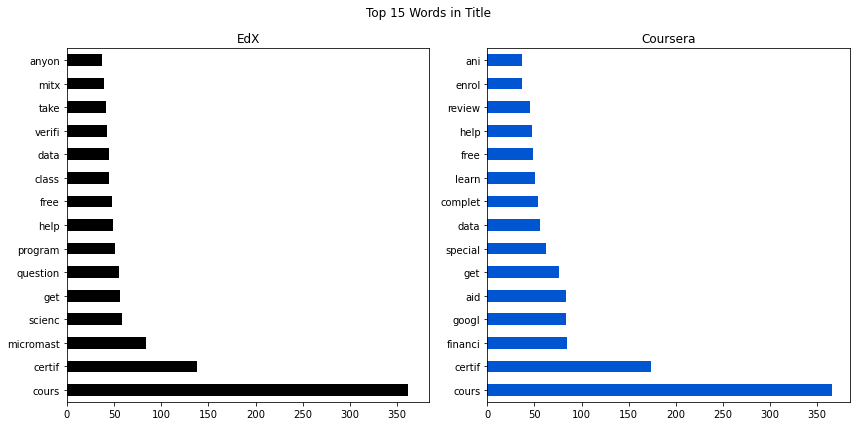

In [23]:
compare_words(vec_choice='cv',grams=(1,1),top_n=15, feature = 'title_stem',
              title='Top 15 Words in Title')

### Lemmatizing - *Count Vectorizer*

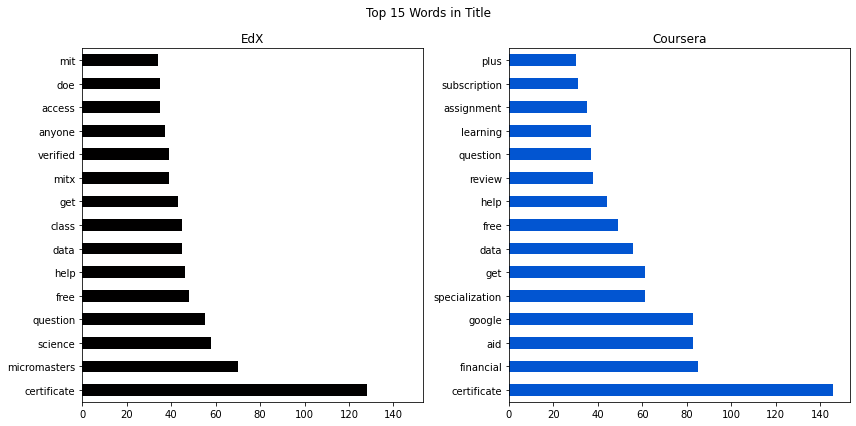

In [24]:
compare_words(vec_choice='cv',grams=(1,1),top_n=15, feature = 'title_lemma',
              title='Top 15 Words in Title')

**We will *lemmatize* our strings before we do EDA for the following reasons:**

- As we can see *vectorizing* alone will separate words that should have been grouped together - e.g. certificate and certificates
- *Stemming* solved that problem, but in terms of EDA, we have lost some readability in our texts
- In this case, *Lemmatizing* solved the problem similarly to stemming and has preserved readibility

---

## Vectorizer Options: Count Vectorizer vs Tf-Idf Vectorizer

Investigating recurring words will allow us to find a distinctions between EdX and Coursera customers in terms of what they talk about, what they discuss or even what they argue about. We may also find out the differences in strengths and weaknesses of EdX and Coursera from their discussions. From the stated idea, here are the few things we will investigate:

- Differences in topics of discussion
- Differences in courses or contents
- Differences in people's expectations

In order to do that, we need to vectorize title strings. In terms of vectorizing, we will explore two methods, *Count Vectorizer* and *Tf-Idf Vectorizer*. Both should yield similar results, but here are the differences between the two methods:<br>

**CountVectorizer:** <br>
- Convert a collection of text documents to a matrix of token counts

**TfIdfVectorizer:** <br>
- Does a CountVectorizer's task followed by a Tf or Tf-Idf transform
- Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

We will carry out a vectorization method comparison of lemmatized title - on uni-gram. The results should provide us with supporting reasons to choose one over the other.

*1. Top 15 Words using CountVectorizer*

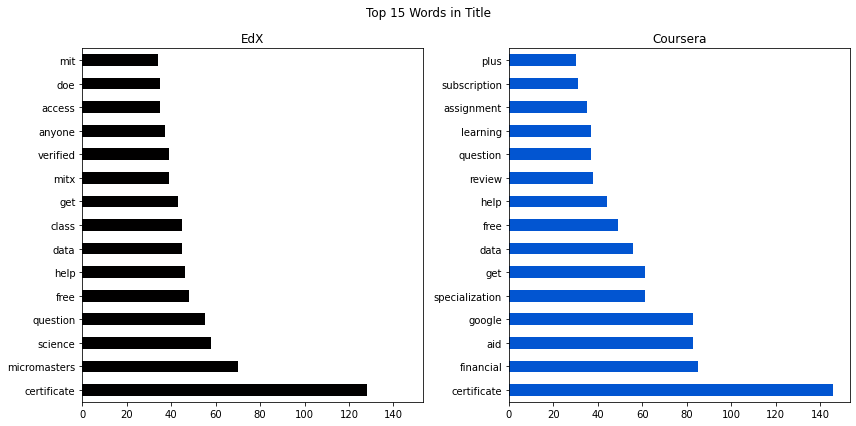

In [25]:
compare_words(vec_choice='cv',feature='title_lemma',grams=(1,1),top_n=15,
              title='Top 15 Words in Title')

*2. Top 15 Words using TfIdfVectorizer*

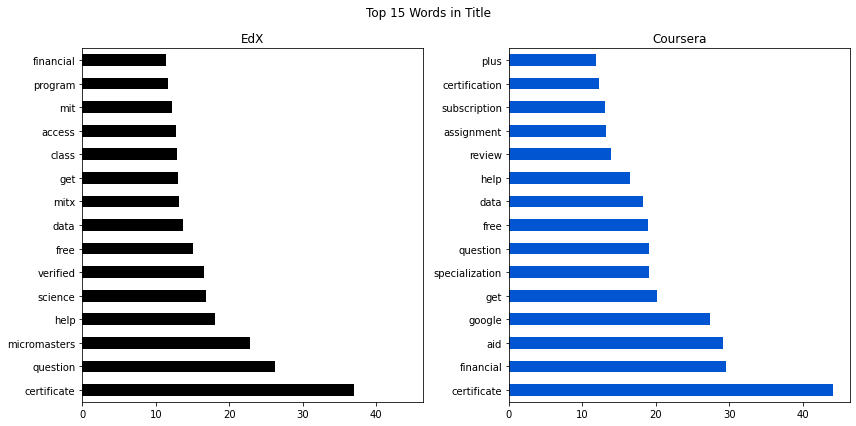

In [26]:
compare_words(vec_choice='tf',feature='title_lemma', grams=(1,1),top_n=15,
              title='Top 15 Words in Title')

**For EDA both will be very similar, so we will select *Count Vectorizer* for the follwing reasons:**

- Number of occurance is a tallied frequency, allowing quick and understandable comparison
- Effects on top recurring words is negligible so selecting both will be fine

---

## We will now carry out recurring word analysis on `title` and `comments` using Lemmatization and Count Vectorizer

### `Title` Analysis

#### *Uni-gram Anaylsis*

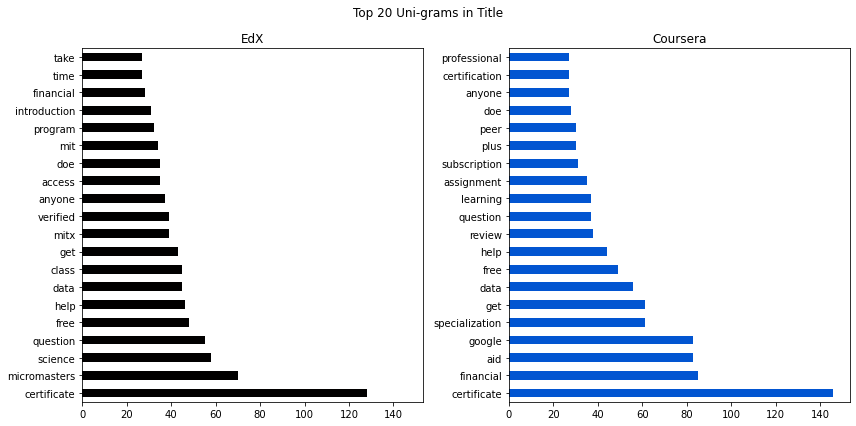

In [27]:
compare_words(vec_choice='cv',feature='title_lemma', grams=(1,1),top_n=20,
              title='Top 20 Uni-grams in Title')

**Key Takeaway** <br>

**Similarities**
- `Certificates` are of importance
- `Questions` are being asked
- and `Financial` seems to be a topic of concern for both communities

**Differences**
- `Micromasters`, `science` stood out for `edx`
- `google` , `specialization` stood out for `coursera`

We will explore in more details

#### *Bigram Anaylsis*

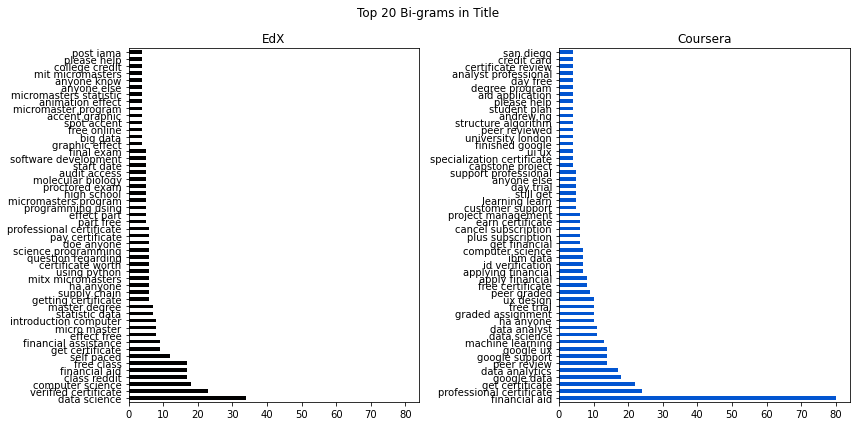

In [28]:
compare_words(vec_choice='cv',feature='title_lemma', grams=(2,2),top_n=50,
              title='Top 20 Bi-grams in Title')

**Key Takeaway** <br>

**Similarities**
- `get certificate` and `verified certificate`
- `financial aid` shows up a lot for both

**Differences**
- for `edx`: `data science` and `computer science` seems to be the main product that create engagement from the community
- while `coursera`: `google data` and `data analytics` which we suspect to be `google data analytics` in a tri-gram analysis is the most popular topic of discussion

We will explore in more details

#### *Trigram Anaylsis*

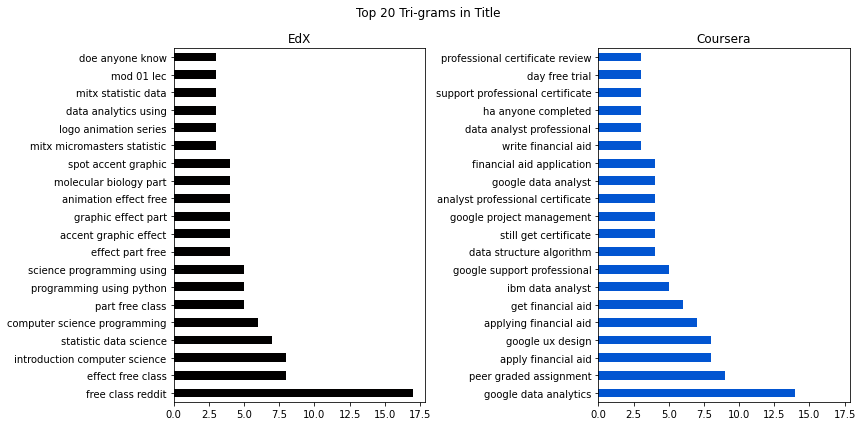

In [29]:
compare_words(vec_choice='cv',grams=(3,3),top_n=20, feature='title_lemma',
              title='Top 20 Tri-grams in Title')

**Key Takeaway** <br>

**Similarities**
- `apply financial aid` and `free clas reddit` goes towards the same idea that communities are both looking for financial supports or discounts

**Differences**
- we can clearly see that the more popular courses on `edx` are `introduction computer science`, `statistic data science`, and `computer science programming`
- while for `coursera` the more popular coursers are `google data analytics`, `google ux design`, and `ibm data analyst`

**Summary of Title Keywords**
- From recurring words analysis, we've seen that both platform draws attention from customers using financial aid services
- Which they then differs by the popular courses each platform provides
- `edx` provides are more university related courses such as `computer science`
- `coursera` provides more industry-based application coursers such as `google data analytics`
- We will explore more into the differences in the comments section

---

### `Comments` Analysis

#### *Uni-gram Anaylsis*

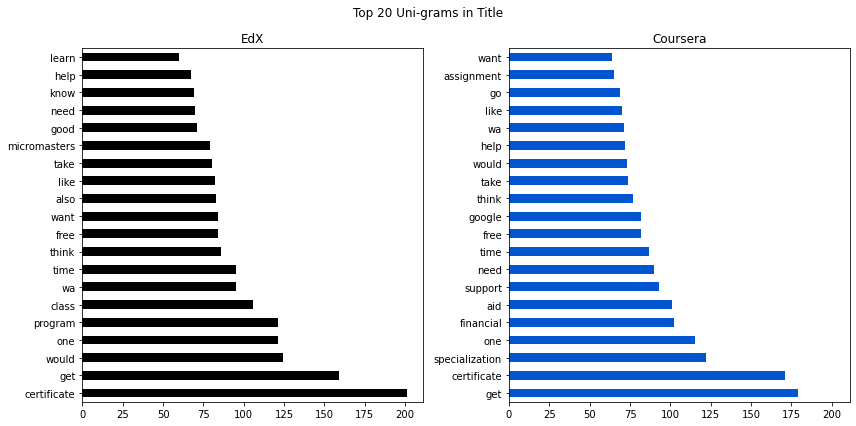

In [30]:
compare_words(vec_choice='cv',left_df = edx_cmts, right_df = coursera_cmts, 
              feature='title_lemma', grams=(1,1),top_n=20,
              title='Top 20 Uni-grams in Title')

#### *Bigram Anaylsis*

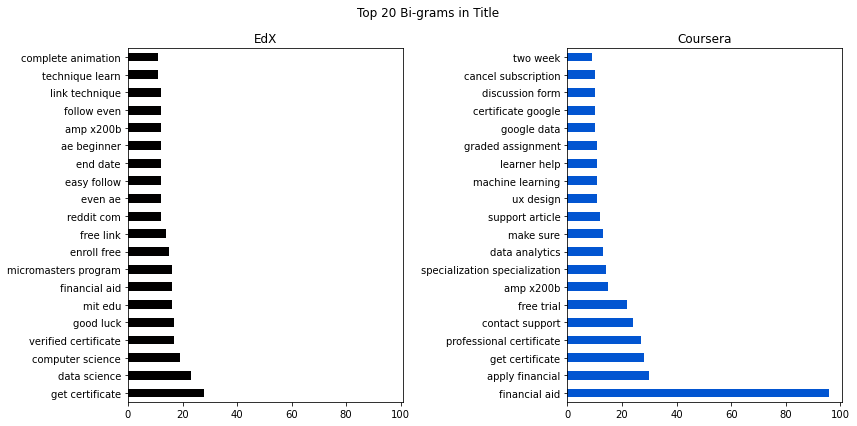

In [31]:
compare_words(vec_choice='cv',left_df = edx_cmts, right_df = coursera_cmts, 
              feature='title_lemma', grams=(2,2),top_n=20,
              title='Top 20 Bi-grams in Title')

#### *Trigram Anaylsis*

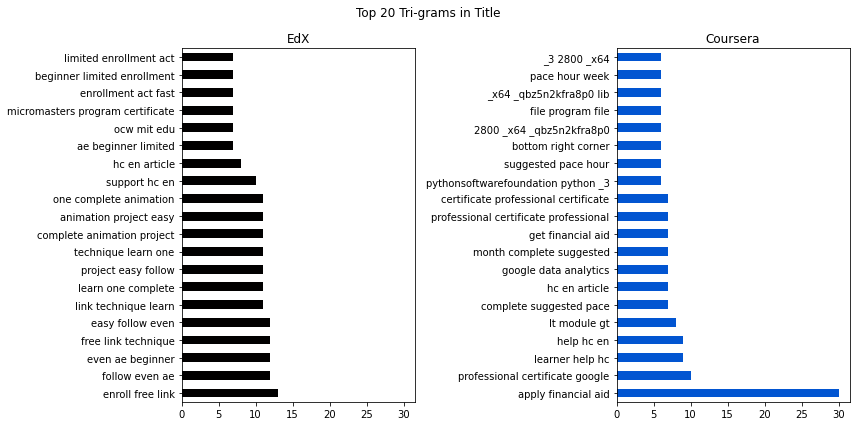

In [32]:
compare_words(vec_choice='cv',left_df = edx_cmts, right_df = coursera_cmts, 
              feature='title_lemma', grams=(3,3),top_n=20,
              title='Top 20 Tri-grams in Title')

**Summary of Comments Keywords**
- Topis of concern are very similar to the title, meaning the comment section generally provides an answer to the questions in the title. We will move on to explore lengths and word counts

---

## `Title` and `Comments` Length and Word Count Analysis

Investigating lengths and word count of title might allow us to see the differences in users' behavior. Debates has been on-going and never-ending in terms of Mac OS Users vs Windows OS Users. We will investigate this stereotypes an potentially findout who writes more descriptive title, who communicates better, or who uses better english.

In [33]:
def compare_hist(feature = 'title_length', comment='n', top=edx_post, kde=False,
                 bottom=coursera_post, b=20, sharex=True):
    
    # Setting up figure and subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8),sharey=True)

    # Plotting EdX distribution
    sns.histplot(x=feature,
                 data=top,
                 bins=b,
                 ax=axes[0],
                 kde=kde,
                 color='#010000')
    axes[0].set_title("EdX")
    
    if feature == 'title_length':
        if comment == 'y':
            axes[0].set_xlabel('Comment Length')
        else:
            axes[0].set_xlabel('Title Length')
    elif feature == 'title_count':
        axes[0].set_xlabel('Word Count')
    elif feature == 'ups':
        axes[0].set_xlabel('Upvotes')
    elif feature == 'upvote_ratio':
        axes[0].set_xlabel('Upvote Ratio')
        
    # Plotting Coursera distribution
    sns.histplot(x=feature,
                 data=bottom,
                 bins=b,
                 ax=axes[1],
                 kde=kde,
                 color='#06acef')
    axes[1].set_title("Coursera")
    
    if feature == 'title_length':
        if comment == 'y':
            axes[1].set_xlabel('Comment Length')
        else:
            axes[1].set_xlabel('Title Length')
    elif feature == 'title_count':
        axes[1].set_xlabel('Word Count')
    elif feature == 'ups':
        axes[1].set_xlabel('Upvotes')
    elif feature == 'upvote_ratio':
        axes[1].set_xlabel('Upvote Ratio') 

    # Adjusting layout
    plt.tight_layout()

#### Title Length

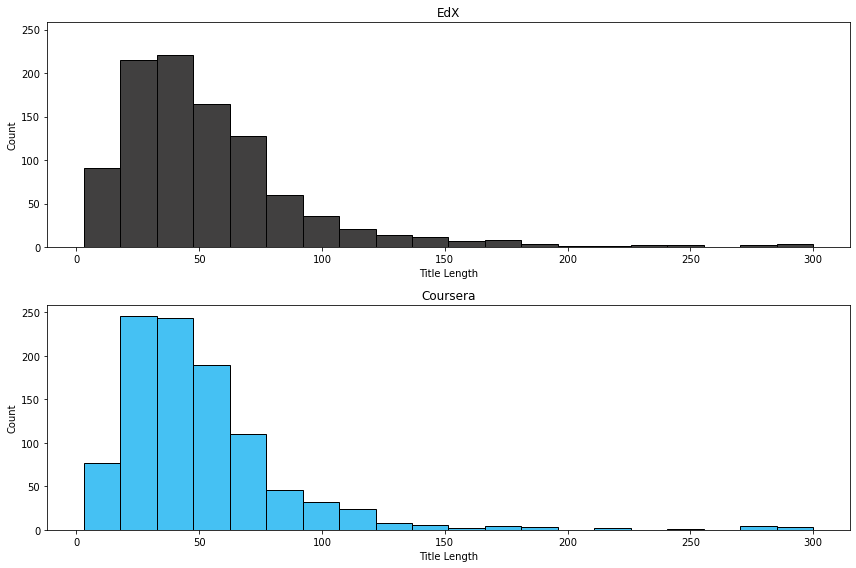

In [34]:
compare_hist(feature='title_length',b=20)

#### Title Word Count

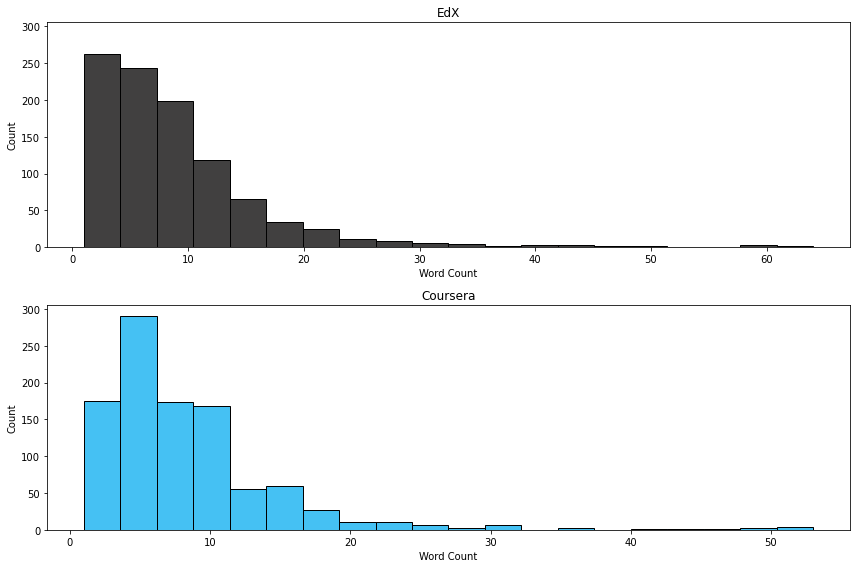

In [35]:
compare_hist(feature='title_count',b=20)

#### Comment Length

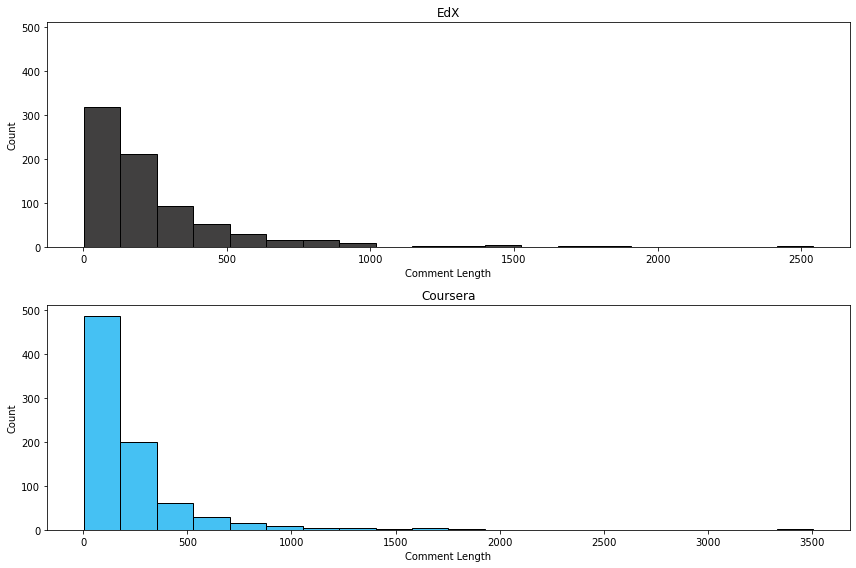

In [36]:
compare_hist(feature='title_length', comment='y', top=edx_cmts, 
             bottom=coursera_cmts, b=20)

#### Comment Word Count

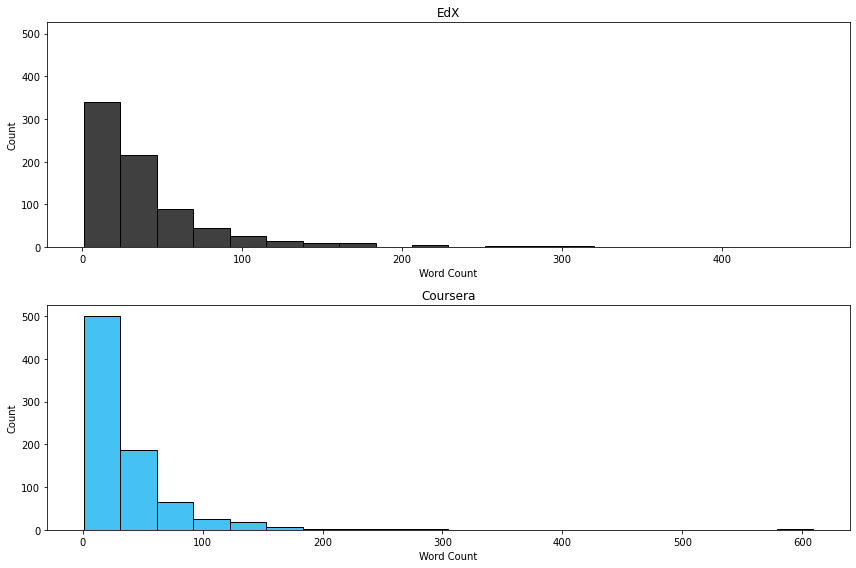

In [37]:
compare_hist(feature='title_count', comment='y', top=edx_cmts, 
             bottom = coursera_cmts, b=20)

**Key Takeaways:** <br>
- Generally the title of both threads do not differ much in terms of word count and legnth
- This will not help to differentiate the two subreddits apart in our model

---

## Upvotes and Upvote ratio Analysis for Threads in EdX and Coursera Subreddit

Investigating upvotes and upvote ratio might help to differentiate both communities in terms of how engaging and active each communities are.

In [38]:
post_df.groupby('subreddit').describe()[['ups','upvote_ratio']].T

subreddit             coursera         edx
ups          count  999.000000  995.000000
             mean     5.814815    5.873367
             std      6.504719    7.819393
             min      0.000000    0.000000
             25%      3.000000    2.000000
             50%      4.000000    4.000000
             75%      7.000000    7.000000
             max    142.000000  142.000000
upvote_ratio count  999.000000  995.000000
             mean     0.920320    0.878533
             std      0.119291    0.141193
             min      0.100000    0.200000
             25%      0.860000    0.810000
             50%      1.000000    0.910000
             75%      1.000000    1.000000
             max      1.000000    1.000000

Both communities does not seem to vary very much in terms of ups and upvote ratio. Let's visualize it on a histogram to see the distribution.

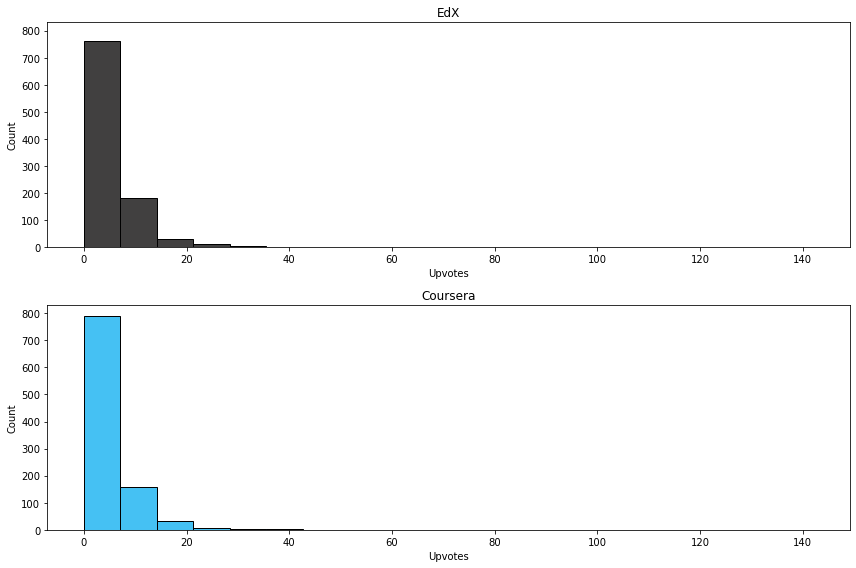

In [39]:
compare_hist(feature='ups', comment='n', top=edx_post, 
             bottom = coursera_post, b=20)

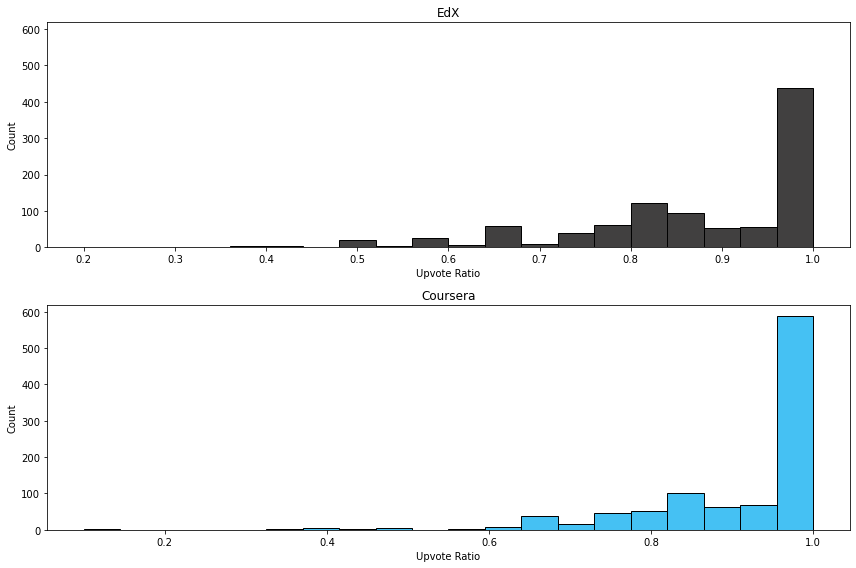

In [40]:
compare_hist(feature='upvote_ratio', comment='n', top=edx_post, 
             bottom = coursera_post, b=20)

**Key Takeaways:** <br>
- Number of upvotes and upvote ratio from both communities have negligible differences
- This didn't provide additional information to differentiate the two subreddits

---